In [1]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases #Package for database reading.
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.visualizations.git
!pip install mne #The MNE Package is installed
FILEID = "1lo0MjWLvsyne2CgTA6VZ2HGY9SKxiwZ7"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MI_EEG_ClassMeth.zip && rm -rf /tmp/cookies.txt
!unzip MI_EEG_ClassMeth.zip #Package with useful functions for motor imagery classification based in EEG.
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models.git
!di


  Cloning https://github.com/UN-GCPDS/python-gcpds.databases to /tmp/pip-req-build-ukyo484h
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.databases /tmp/pip-req-build-ukyo484h
  Resolved https://github.com/UN-GCPDS/python-gcpds.databases to commit d174df9958b6638156dcfe03996a6307e631a6a2
  Preparing metadata (setup.py) ... done
  Created wheel for gcpds-databases: filename=gcpds_databases-0.2-py3-none-any.whl size=32972809 sha256=ecb96011a9f89241ab848f797de9633116f00a00c16790ce3932a4fdf18ce179
  Stored in directory: /tmp/pip-ephem-wheel-cache-ne95mnoa/wheels/ae/48/8d/edf617d5fe8f03b17aa26306a04abdfcc605b218d8e6deac83
Successfully built gcpds-databases
  Cloning https://github.com/UN-GCPDS/python-gcpds.visualizations.git to /tmp/pip-req-build-pynu_4o4
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.visualizations.git /tmp/pip-req-build-pynu_4o4
  Resolved https://github.com/UN-GCPDS/python-

In [2]:
from gcpds.databases.BCI_Competition_IV import Dataset_2a
from typing import Sequence, Tuple
from MI_EEG_ClassMeth.FeatExtraction import TimeFrequencyRpr
import numpy as np
from scipy.signal import iirnotch, filtfilt, butter
import matplotlib.pyplot as plt
from scipy.spatial import distance
import networkx as nx
from tqdm import tqdm
import mne
from mne.preprocessing import compute_current_source_density
from mne.channels import make_standard_montage, read_custom_montage
import numpy as np
from scipy.signal import butter, filtfilt, resample, iirnotch
import h5py
from gcpds.visualizations.series import plot_eeg
from scipy.stats import norm
import itertools
import random
import pickle
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from tqdm import tqdm
import os

In [3]:
import itertools
import random
import pickle
import mne
import h5py
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt


from gcpds.databases.BCI_Competition_IV import Dataset_2a
from typing import Sequence, Tuple
from MI_EEG_ClassMeth.FeatExtraction import TimeFrequencyRpr
from scipy.signal import iirnotch, filtfilt, butter, freqz
import matplotlib.pyplot as plt
from scipy.spatial import distance
import networkx as nx
from tqdm import tqdm
from mne.preprocessing import compute_current_source_density
from mne.channels import make_standard_montage, read_custom_montage
from scipy.signal import butter, filtfilt, resample, iirnotch
from gcpds.visualizations.series import plot_eeg
from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from tqdm import tqdm

from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from gcpds.databases import GIGA_MI_ME
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import LeavePGroupsOut, StratifiedGroupKFold
from tensorflow.keras.models import Model
from scipy.spatial.distance import cdist
from sklearn.model_selection import GroupKFold
from tensorflow.keras.models import load_model
import keras_tuner as kt
import tensorflow_probability as tfp
from tensorflow.keras.metrics import BinaryAccuracy, Recall

2025-08-26 14:27:40.993827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756218461.350768      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756218461.450484      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def segment_data(data, fs, segment_duration=2, overlap=0.5):
    segment_samples = int(segment_duration * fs)
    step_samples = int(segment_samples * (1 - overlap))
    n_trials, n_channels, n_timepoints = data.shape

    segments = []
    count_segments = 0  # Contador para ventanas generadas

    for trial in range(n_trials):
        for start in range(0, n_timepoints - segment_samples + 1, step_samples):
            segments.append(data[trial, :, start:start + segment_samples])
            count_segments += 1  # Incrementar el contador
    
    print(f"Número total de ventanas generadas: {count_segments}")
    return np.array(segments)
def load_BCICIV2a(db, sbj: int, mode: str, fs: float, new_fs: float = 250.0) -> tuple:
    """
    Carga los datos EEG para un sujeto específico con preprocesamiento, incluyendo segmentación y laplaciano superficial.

    Args:
        db (Dataset_2a): Objeto del dataset.
        sbj (int): Identificador del sujeto (1-9).
        mode (str): 'training' o 'testing'.
        fs (float): Frecuencia de muestreo original.
        new_fs (float): Nueva frecuencia de muestreo. Por defecto, 128 Hz.

    Returns:
        tuple: Datos EEG preprocesados con laplaciano superficial y segmentados (X), etiquetas (y).
    """
    # Cargar los datos del sujeto
    db.load_subject(sbj, mode=mode)
    X, y = db.get_data()  # Datos y etiquetas
    X = X[:, :-3, :]  # Seleccionar solo los canales EEG (22 canales)
    X = X * 1e6  # Convertir a microvoltios

    # Aplicar filtro Notch (50 Hz)
    notch_freq = 50.0
    q_factor = 30.0
    b_notch, a_notch = iirnotch(w0=notch_freq, Q=q_factor, fs=fs)
    X = filtfilt(b_notch, a_notch, X, axis=2)

    # Aplicar filtro pasa banda (0.5 - 100 Hz)
    lowcut = 0.5
    highcut = 100.0
    b_band, a_band = butter(N=4, Wn=[lowcut, highcut], btype='bandpass', fs=fs)
    X = filtfilt(b_band, a_band, X, axis=2)

    # Remuestreo si la frecuencia de muestreo deseada es distinta a la original
    if new_fs != fs:
        print(f"Resampling from {fs} to {new_fs} Hz.")
        num_samples = int((X.shape[-1] / fs) * new_fs)
        X = resample(X, num_samples, axis=2)
    else:
        print("No resampling, since new sampling rate is the same.")

    # Segmentar los datos
    X_segmented = segment_data(X, fs=new_fs, segment_duration=2, overlap=0.5)

    # Lista de nombres de los 22 canales EEG (sin EOG)
    eeg_channel_names = [
        'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
        'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz'
    ]

    # Crear información para los canales EEG
    info = mne.create_info(
        ch_names=eeg_channel_names,
        sfreq=new_fs if new_fs != fs else fs,  # Usar la nueva frecuencia si se remuestrea
        ch_types=["eeg"] * len(eeg_channel_names)  # Todos los canales son EEG
    )

    # Cargar un montaje estándar basado en el sistema 10/20
    montage = mne.channels.make_standard_montage('standard_1020')
    info.set_montage(montage)

    # Aplicar el cálculo del laplaciano superficial segmento por segmento
    laplacian_X = []
    for segment in X_segmented:
        # Crear un objeto RawArray para cada segmento
        raw = mne.io.RawArray(segment, info)
        # Calcular el laplaciano superficial
        raw = mne.preprocessing.compute_current_source_density(raw)
        # Obtener los datos con el laplaciano aplicado
        laplacian_X.append(raw.get_data())

    # Reconvertir a un array numpy con la misma forma original
    X = np.stack(laplacian_X)

    return X, y

In [5]:
def load_all_subjects(db: Dataset_2a, mode='training', fs: float = 250.0):
    """
    Carga los datos EEG de todos los sujetos y los combina en un único conjunto.

    Args:
        db (Dataset_2a): Objeto del dataset.
        mode (str): 'training' o 'testing'.
        fs (float): Frecuencia de muestreo original.

    Returns:
        Tuple[np.ndarray, np.ndarray, list]: Datos combinados, etiquetas y lista de sujetos.
    """
    X_all = []
    y_all = []
    subjects = []

    for subject in range(1, 10):  # Iterar sobre los 9 sujetos 
        print(f"Cargando datos del sujeto {subject}...")  # Imprimir mensaje
        X, y = load_BCICIV2a(db=db, sbj=subject, mode=mode, fs=fs)
        X_all.append(X)
        y_all.append(y)
        subjects.extend([subject] * len(y))  # Guardar el identificador del sujeto para cada ensayo

    # Concatenar datos
    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)

    return X_all, y_all, subjects

In [6]:
# Crear instancia del dataset
db = Dataset_2a('/kaggle/input/dataset-2a')

# Cargar datos de todos los sujetos
X_combined, y_combined, subjects = load_all_subjects(
    db=db,
    mode='training',  # Modo: 'training' o 'testing'
    fs=250.0          # Frecuencia de muestreo en Hz
)

Cargando datos del sujeto 1...
No resampling, since new sampling rate is the same.
Número total de ventanas generadas: 1638
Cargando datos del sujeto 2...
No resampling, since new sampling rate is the same.
Número total de ventanas generadas: 1620
Cargando datos del sujeto 3...
No resampling, since new sampling rate is the same.
Número total de ventanas generadas: 1620
Cargando datos del sujeto 4...
No resampling, since new sampling rate is the same.
Número total de ventanas generadas: 1572
Cargando datos del sujeto 5...
No resampling, since new sampling rate is the same.
Número total de ventanas generadas: 1572
Cargando datos del sujeto 6...
No resampling, since new sampling rate is the same.
Número total de ventanas generadas: 1314
Cargando datos del sujeto 7...
No resampling, since new sampling rate is the same.
Número total de ventanas generadas: 1626
Cargando datos del sujeto 8...
No resampling, since new sampling rate is the same.
Número total de ventanas generadas: 1584
Cargando

In [8]:
X_combined.shape

(13968, 22, 500)

# Kus_Model

In [9]:
def generate_kus_model_G1(X, var_scale=0.25, interaction_delays=(4, 8)):
    """
    Genera el modelo Kus modificado con 5 canales.
    
    Args:
        X (np.ndarray): Datos de entrada con forma (n_trials, n_channels, n_time).
        var_scale (float): Escala del ruido blanco gaussiano.
        interaction_delays (tuple): Retrasos de interacción para los canales.

    Returns:
        np.ndarray: Conjunto de datos generado con forma (n_trials, 5, n_time).
    """
    n_trials, n_channels, n_time = X.shape 

    # Para simplificar, usamos solo el primer canal como base del modelo Kus
    X_base = X[:, 0, :]  # Base temporal de los datos (Fz, por ejemplo)
    v = var_scale * np.var(X_base)  # Escala del ruido

    def noise():
        return np.sqrt(v) * np.random.randn(n_trials, n_time)

    x1 = X_base + noise()
    delay1 = interaction_delays[0]
    
    x2 = noise()
    if delay1 < n_time:
        x2[:, delay1:] += 0.4 * x1[:, :-delay1]

    x3 = noise()
    if delay1 < n_time:
        x3[:, delay1:] += 0.4 * x2[:, :-delay1]

    delay2 = interaction_delays[1]
    x4 = noise()
    if delay2 < n_time:
        x4[:, delay2:] += 0.4 * x2[:, :-delay2]

    x5 = noise()
    return np.stack([x1, x2, x3, x4, x5], axis=1)

In [10]:
def generate_kus_model_G2(X, var_scale=0.25, interaction_delays=(4, 8)):
    """
    Genera el modelo Kus alterno (G2) con 5 canales.
    Esquema:
        1 -> 3 (delay1)
        3 -> 2 (delay1)
        3 -> 4 (delay2)
        5 = ruido

    Args:
        X (np.ndarray): Datos de entrada con forma (n_trials, n_channels, n_time).
        var_scale (float): Escala del ruido blanco gaussiano (relativa a la var del canal base).
        interaction_delays (tuple): (delay1, delay2) para las conexiones.

    Returns:
        np.ndarray: Conjunto de datos generado con forma (n_trials, 5, n_time).
    """
    n_trials, n_channels, n_time = X.shape

    # Usamos el primer canal como base (p. ej., Fz)
    X_base = X[:, 0, :]
    v = var_scale * np.var(X_base)

    def noise():
        return np.sqrt(v) * np.random.randn(n_trials, n_time)

    x1 = X_base + noise()

    delay1, delay2 = interaction_delays

    # Inicializamos con ruido
    x2 = noise()
    x3 = noise()
    x4 = noise()
    x5 = noise()  # ruido puro

    # 1 -> 3 (delay1)
    if delay1 < n_time:
        x3[:, delay1:] += 0.4 * x1[:, :-delay1]

    # 3 -> 2 (delay1)
    if delay1 < n_time:
        x2[:, delay1:] += 0.4 * x3[:, :-delay1]

    # 3 -> 4 (delay2)
    if delay2 < n_time:
        x4[:, delay2:] += 0.4 * x3[:, :-delay2]

    return np.stack([x1, x2, x3, x4, x5], axis=1)

# set_global_seed(SEED)CustomLayers

In [11]:
@register_keras_serializable(package="CustomLayers")
class TakensConv1D(tf.keras.layers.Layer):
    def __init__(self, dx=5, dy=5, tau=1, mu=4, **kwargs):
        super().__init__(**kwargs)
        self.dx = int(dx)
        self.dy = int(dy)
        self.tau = int(tau)
        self.mu = int(mu)
        self.num_filters = self.dx + self.dy + 1

    def build(self, input_shape):
        kernel_size = self.mu + (self.dx - 1) * self.tau + 1
        kernel_shape = (kernel_size, 1, self.num_filters)
        kernel = tf.zeros(kernel_shape, dtype=tf.float32)

        offsets_x = self.mu + tf.range(self.dx) * self.tau
        offsets_y = tf.range(1, self.dy + 1) * self.tau
        offset_y_t = tf.constant([0], dtype=tf.int32)

        filas_x = tf.range(self.dx)
        filas_y = self.dx + tf.range(self.dy)
        fila_y_t = tf.constant([self.dx + self.dy])

        cols_x = filas_x
        cols_y = filas_y
        col_y_t = fila_y_t

        idx_x = tf.stack([filas_x, offsets_x, cols_x], axis=1)
        idx_y = tf.stack([filas_y, offsets_y, cols_y], axis=1)
        idx_yt = tf.stack([fila_y_t, offset_y_t, col_y_t], axis=1)

        indices_total = tf.concat([idx_x, idx_y, idx_yt], axis=0)
        updates = tf.ones([tf.shape(indices_total)[0]], dtype=tf.float32)

        sort_order = tf.argsort(indices_total[:, 0])
        indices_sorted = tf.gather(indices_total, sort_order)

        row_for_scatter = tf.cast(indices_sorted[:, 1], tf.int32)
        col_for_scatter = tf.cast(indices_sorted[:, 2], tf.int32)

        final_indices = tf.stack([row_for_scatter,
                                  tf.zeros_like(row_for_scatter),
                                  col_for_scatter], axis=1)

        kernel = tf.scatter_nd(final_indices, updates, kernel_shape)
        self.kernel = kernel.numpy()[::-1]

        self.conv1d = tf.keras.layers.Conv1D(
            filters=self.num_filters,
            kernel_size=kernel_size,
            strides=self.tau,
            padding="valid",
            use_bias=False
        )
        self.conv1d.build((None, input_shape[2], 1))
        self.conv1d.set_weights([self.kernel])
        self.conv1d.trainable=False

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        channels = tf.shape(inputs)[1]
        time_steps = tf.shape(inputs)[2]

        reshaped = tf.reshape(inputs, (-1, time_steps, 1))
        conv_output = self.conv1d(reshaped)
        new_time = tf.shape(conv_output)[1]

        output = tf.reshape(conv_output, 
                            (batch_size, channels, new_time, self.num_filters))

        x_sub_t_minus_mu = output[..., :self.dx]
        y_sub_t_minus_1 = output[..., self.dx:self.dx + self.dy]
        y_sub_t = output[..., -1:]

        return x_sub_t_minus_mu, y_sub_t_minus_1, y_sub_t
       

@register_keras_serializable(package="CustomLayers")
class KernelLayer(tf.keras.layers.Layer):
    def __init__(self, 
                 amplitude=1.0,
                 trainable_amplitude=False, 
                 length_scale=1.0,
                 trainable_length_scale=False,
                 alpha=1.0,  # Solo usado para Rational Quadratic
                 trainable_alpha=False,
                 kernel_type="gaussian",  # "gaussian" o "rational_quadratic"
                 **kwargs):
        super(KernelLayer, self).__init__(**kwargs)

        self.init_amplitude = amplitude
        self.trainable_amplitude = trainable_amplitude
        self.init_length_scale = length_scale
        self.trainable_length_scale = trainable_length_scale
        self.init_alpha = alpha
        self.trainable_alpha = trainable_alpha
        self.kernel_type = kernel_type.lower()

    def build(self, input_shape):
        self.amplitude = self.add_weight(
            name="amplitude",
            shape=(),
            initializer=tf.constant_initializer(self.init_amplitude),
            trainable=self.trainable_amplitude,
            dtype=self.dtype
        )

        self.length_scale = self.add_weight(
            name="length_scale",
            shape=(),
            initializer=tf.constant_initializer(self.init_length_scale),
            trainable=self.trainable_length_scale,
            dtype=self.dtype
        )

        if self.kernel_type == "rational_quadratic":
            self.alpha = self.add_weight(
                name="alpha",
                shape=(),
                initializer=tf.constant_initializer(self.init_alpha),
                trainable=self.trainable_alpha,
                dtype=self.dtype
            )

        super(KernelLayer, self).build(input_shape)

    def call(self, X):
        if self.kernel_type == "gaussian":
            kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(
                amplitude=self.amplitude,
                length_scale=self.length_scale
            )
        elif self.kernel_type == "rational_quadratic":
            kernel = tfp.math.psd_kernels.RationalQuadratic(
                amplitude=self.amplitude,
                length_scale=self.length_scale,
                scale_mixture_rate=self.alpha
            )
        else:
            raise ValueError(f"Unsupported kernel_type: {self.kernel_type}")
        
        return kernel.matrix(X, X)
       
@register_keras_serializable(package="CustomLayers")
class TransferEntropyLayer(tf.keras.layers.Layer):
    def __init__(self, alpha=2, **kwargs):

        super().__init__(**kwargs)
        self.alpha = int(alpha)

    def compute_entropy(self, K_hadamard):
        
        trace_hadamard = tf.reduce_sum(tf.linalg.diag_part(K_hadamard), axis=-1) 
        trace_hadamard = tf.expand_dims(tf.expand_dims(trace_hadamard, axis=-1), axis=-1)
        K_normalized = K_hadamard / trace_hadamard

        K_power = tf.linalg.matmul( K_normalized , K_normalized, grad_a=True, grad_b=True ) 
        trace_power = tf.reduce_sum(tf.linalg.diag_part(K_power), axis=-1)  
        H_alpha = (1 / (1 - self.alpha)) * tf.math.log(trace_power)
        return H_alpha

    def call(self, K_x, K_y_minus_1, K_y):
        
        K_x_exp = tf.expand_dims(K_x, axis=2)
        
        K_y_minus_1_exp = tf.expand_dims(K_y_minus_1, axis=1)
        K_y_exp = tf.expand_dims(K_y, axis=1)

        
        H_1 = self.compute_entropy(K_y_minus_1_exp * K_x_exp)
        H_2 = self.compute_entropy(K_y_exp * K_y_minus_1_exp * K_x_exp)
        H_3 = self.compute_entropy(K_y_exp * K_y_minus_1_exp)
        H_4 = self.compute_entropy(K_y_minus_1_exp)

        TE = H_1 - H_2 + H_3 - H_4
        
        return TE
        
@register_keras_serializable(package="CustomLayers")      
class RemoveDiagonalFlatten(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
    
        super().__init__(**kwargs)

    def call(self, inputs):
        
        shape_dyn = tf.shape(inputs)  
        batch_size = shape_dyn[0]
        c = tf.shape(inputs)[1]

        
        tf.debugging.assert_equal(
            tf.shape(inputs)[1], tf.shape(inputs)[2],
            message="RemoveDiagonalFlatten: la matriz de entrada no es cuadrada."
        )  
        diag_mask = tf.eye(c, dtype=inputs.dtype)  
        inputs_no_diag = inputs * (1 - diag_mask) 
        flattened = tf.reshape(inputs_no_diag, [batch_size, -1])  
        non_diag = tf.boolean_mask(flattened, tf.reshape(1 - diag_mask, [-1]), axis=1)
        num_features = c * (c - 1)  
        result = tf.reshape(non_diag, [batch_size, num_features])  

        return result

In [12]:
from tensorflow.keras.metrics import Metric
@register_keras_serializable(package="CustomMetrics")
class Sensitivity(Metric):
    def __init__(self, name='sensitivity', **kwargs):
        super().__init__(name=name, **kwargs)
        self.tp = tf.keras.metrics.TruePositives()
        self.fn = tf.keras.metrics.FalseNegatives()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.tp.update_state(y_true, y_pred, sample_weight)
        self.fn.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.tp.result() / (self.tp.result() + self.fn.result() + tf.keras.backend.epsilon())

    def reset_states(self):
        self.tp.reset_states()
        self.fn.reset_states()

    def get_config(self):
        base_config = super().get_config()
        return base_config


@register_keras_serializable(package="CustomMetrics")
class Accuracy(Metric):
    def __init__(self, name='accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.tp = tf.keras.metrics.TruePositives()
        self.tn = tf.keras.metrics.TrueNegatives()
        self.fp = tf.keras.metrics.FalsePositives()
        self.fn = tf.keras.metrics.FalseNegatives()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.tp.update_state(y_true, y_pred, sample_weight)
        self.tn.update_state(y_true, y_pred, sample_weight)
        self.fp.update_state(y_true, y_pred, sample_weight)
        self.fn.update_state(y_true, y_pred, sample_weight)

    def result(self):
        num = self.tp.result() + self.tn.result()
        den = num + self.fp.result() + self.fn.result() + tf.keras.backend.epsilon()
        return num / den

    def reset_states(self):
        self.tp.reset_states()
        self.tn.reset_states()
        self.fp.reset_states()
        self.fn.reset_states()

    def get_config(self):
        base_config = super().get_config()
        return base_config


@register_keras_serializable(package="CustomMetrics")
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.tp = tf.keras.metrics.TruePositives()
        self.fp = tf.keras.metrics.FalsePositives()
        self.fn = tf.keras.metrics.FalseNegatives()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.tp.update_state(y_true, y_pred, sample_weight)
        self.fp.update_state(y_true, y_pred, sample_weight)
        self.fn.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.tp.result() / (self.tp.result() + self.fp.result() + tf.keras.backend.epsilon())
        recall = self.tp.result() / (self.tp.result() + self.fn.result() + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.tp.reset_states()
        self.fp.reset_states()
        self.fn.reset_states()

    def get_config(self):
        base_config = super().get_config()
        return base_config


@register_keras_serializable(package="CustomMetrics")
class Specificity(Metric):
    def __init__(self, name='specificity', **kwargs):
        super().__init__(name=name, **kwargs)
        self.tn = tf.keras.metrics.TrueNegatives()
        self.fp = tf.keras.metrics.FalsePositives()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.tn.update_state(y_true, y_pred, sample_weight)
        self.fp.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.tn.result() / (self.tn.result() + self.fp.result() + tf.keras.backend.epsilon())

    def reset_states(self):
        self.tn.reset_states()
        self.fp.reset_states()

    def get_config(self):
        base_config = super().get_config()
        return base_config

In [13]:
def create_tunable_model(dx, dy, tau, mu,
                         kernel_type, learning_rate,
                         kernel_size,
                         dropout_rate): 
    input_eeg = tf.keras.Input(shape=(5, 500), name='input_eeg')

    x = tf.keras.layers.DepthwiseConv1D(
        kernel_size=kernel_size,
        strides=1,
        padding='valid',
        activation='relu',
        depth_multiplier=1,
        data_format="channels_first",
        name='block1_depthwise_conv1d'
    )(input_eeg)

    x = tf.keras.layers.AveragePooling1D(
        pool_size=4,
        strides=4,
        padding='valid',
        data_format="channels_first",
        name='block1_avg_pooling'
    )(x)

    x = tf.keras.layers.Dropout(dropout_rate, name='block1_dropout')(x)

    x = tf.keras.layers.BatchNormalization(
        axis=1,
        name='block1_batch_norm'
    )(x)

    # Bloque 2: TakensConv1D
    takens = TakensConv1D(dx=dx, dy=dy, tau=tau, mu=mu, name='takens_conv1d')(x)
    x_sub, y_minus_1, y_t = takens

    # Proyecciones densas
    x_sub = tf.keras.layers.Dense(dx, activation=None, use_bias=False, name='dense_proj_x')(x_sub)
    y_minus_1 = tf.keras.layers.Dense(dy, activation=None, use_bias=False, name='dense_proj_y_1')(y_minus_1)
    y_t = tf.keras.layers.Dense(1, activation=None, use_bias=False, name='dense_proj_y')(y_t)

    # Kernel layers fijos
    def fixed_kernel(name):
        layer = KernelLayer(
            amplitude=1.0, trainable_amplitude=False,
            length_scale=1.0, trainable_length_scale=False,
            alpha=1.0, trainable_alpha=False,
            kernel_type=kernel_type,
            name=name
        )
        layer.trainable = False
        return layer

    Kx = fixed_kernel('kernel_x')(x_sub)
    Ky1 = fixed_kernel('kernel_y_minus_1')(y_minus_1)
    Ky = fixed_kernel('kernel_y')(y_t)

    # Transferencia de entropía + aplanado
    TE = TransferEntropyLayer(alpha=2, name='transfer_entropy')(Kx, Ky1, Ky)
    flat = RemoveDiagonalFlatten(name='remove_diag_flatten')(TE)

    h = tf.keras.layers.Dense(10, activation='relu', name='dense_1')(flat)
    h = tf.keras.layers.Dropout(dropout_rate, name='dense_dropout')(h)

    out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(h)

    model = tf.keras.Model(inputs=input_eeg, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            BinaryAccuracy(name='accuracy'),
            F1Score(name='f1_score'),
            Recall(name='sensitivity'),
            Specificity(name='specificity')
        ]
    )
    return model

In [14]:
n_per_class = 2000
var_scale   = 0.25
delays      = (4, 8)

# Selección de índices sin reemplazo
idx_perm = np.random.permutation(X_combined.shape[0])
idx_G1   = idx_perm[:n_per_class]
idx_G2   = idx_perm[n_per_class:2*n_per_class]

# Construcción de datasets Kus
X_G1 = generate_kus_model_G1(X_combined[idx_G1], var_scale=var_scale, interaction_delays=delays)  # (2000,5,500)
X_G2 = generate_kus_model_G2(X_combined[idx_G2], var_scale=var_scale, interaction_delays=delays)  # (2000,5,500)

# Concatenar y crear etiquetas
X = np.concatenate([X_G1, X_G2], axis=0)  # (4000,5,500)
y = np.concatenate([
    np.zeros(n_per_class, dtype=np.int32),  # 0 = G1
    np.ones(n_per_class,  dtype=np.int32)   # 1 = G2
])

# Mezclar
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

print("Dataset final:", X.shape, y.shape, "Balance:", np.bincount(y))

Dataset final: (4000, 5, 500) (4000,) Balance: [2000 2000]


In [15]:
def takens_is_compatible(T_in, kernel_size_block1, pool_size=4, stride=4, dx=4, tau=1, mu=4):
    """
    padding='valid' en Conv1D (stride=1) y AvgPool1D (pool_size=stride=4).
    L_conv = T_in - k + 1
    L_pool = floor((L_conv - pool_size)/stride) + 1
    kernel_takens = mu + (dx - 1)*tau + 1
    """
    L_conv  = T_in - kernel_size_block1 + 1
    if L_conv < 1:
        return False, (L_conv, None, None)
    L_pool  = (L_conv - pool_size) // stride + 1
    kernel_takens = mu + (dx - 1)*tau + 1
    ok = L_pool >= kernel_takens
    return ok, (L_conv, L_pool, kernel_takens)


def build_model(hp):
    # Espacio de hiperparámetros
    dx   = hp.Int("dx",   3, 8, step=1)
    dy   = hp.Int("dy",   3, 8, step=1)
    tau  = hp.Int("tau",  1, 3, step=1)
    mu   = hp.Int("mu",   3, 8, step=1)

    kernel_size = hp.Choice("kernel_size", [31, 47, 63, 79, 95])
    dropout     = hp.Float("dropout_rate", 0.10, 0.50, step=0.05)
    head_units  = hp.Choice("head_units", [32, 64, 128])
    lr          = hp.Float("learning_rate", 1e-4, 5e-3, sampling="log")
    kernel_type = hp.Choice("kernel_type", ["gaussian", "rational_quadratic"])

    # Chequeo de forma para Takens (evita trials inválidos)
    ok, (L_conv, L_pool, kernel_takens) = takens_is_compatible(
        T_in=500, kernel_size_block1=kernel_size,
        pool_size=4, stride=4, dx=dx, tau=tau, mu=mu
    )
    if not ok:
        # fallar trial incompatible y que el tuner pruebe otra combinación
        raise kt.errors.FatalTypeError(
            f"Incompatible shapes: L_conv={L_conv}, L_pool={L_pool}, "
            f"kernel_takens={kernel_takens} con (dx={dx}, tau={tau}, mu={mu}, k={kernel_size})."
        )

   
    input_eeg = tf.keras.Input(shape=(5, 500), name='input_eeg')

    x = tf.keras.layers.DepthwiseConv1D(
        kernel_size=kernel_size, strides=1, padding='valid',
        activation='relu', depth_multiplier=1,
        data_format="channels_first", name='block1_depthwise_conv1d'
    )(input_eeg)

    x = tf.keras.layers.AveragePooling1D(
        pool_size=4, strides=4, padding='valid',
        data_format="channels_first", name='block1_avg_pooling'
    )(x)

    x = tf.keras.layers.Dropout(dropout, name='block1_dropout')(x)
    x = tf.keras.layers.BatchNormalization(axis=1, name='block1_batch_norm')(x)

    # Takens
    x_sub, y_minus_1, y_t = TakensConv1D(dx=dx, dy=dy, tau=tau, mu=mu, name='takens_conv1d')(x)

    # Proyecciones densas
    x_sub     = tf.keras.layers.Dense(dx, activation=None, use_bias=False, name='dense_proj_x')(x_sub)
    y_minus_1 = tf.keras.layers.Dense(dy, activation=None, use_bias=False, name='dense_proj_y_1')(y_minus_1)
    y_t       = tf.keras.layers.Dense(1,  activation=None, use_bias=False, name='dense_proj_y')(y_t)

    # Kernel layers fijos
    def fixed_kernel(name):
        layer = KernelLayer(
            amplitude=1.0, trainable_amplitude=False,
            length_scale=1.0, trainable_length_scale=False,
            alpha=1.0,   trainable_alpha=False,
            kernel_type=kernel_type,
            name=name
        )
        layer.trainable = False
        return layer

    Kx  = fixed_kernel('kernel_x')(x_sub)
    Ky1 = fixed_kernel('kernel_y_minus_1')(y_minus_1)
    Ky  = fixed_kernel('kernel_y')(y_t)

    # Transfer Entropy + flatten sin diagonal
    TE   = TransferEntropyLayer(alpha=2, name='transfer_entropy')(Kx, Ky1, Ky)
    flat = RemoveDiagonalFlatten(name='remove_diag_flatten')(TE)

    # Cabeza
    flat = tf.keras.layers.LayerNormalization(name='flat_ln')(flat)
    h    = tf.keras.layers.Dense(head_units, activation='relu', name='dense_1')(flat)
    h    = tf.keras.layers.Dropout(dropout, name='dense_dropout')(h)
    out  = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(h)

    model = tf.keras.Model(inputs=input_eeg, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[
            BinaryAccuracy(name='accuracy'),
            F1Score(name='f1_score'),
            Recall(name='sensitivity'),
            Specificity(name='specificity')
        ]
    )
    return model


perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]
n = len(X)
n_train = int(0.70 * n)
n_val   = int(0.15 * n)
X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]


tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective=kt.Objective("val_accuracy", direction="max"),
    max_trials=30,
    num_initial_points=8,
    directory="tuner_kus",
    project_name="G1_vs_G2_5ch_valacc",
    # sube la tolerancia a fallos por combinaciones inválidas
    max_consecutive_failed_trials=20
)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, min_lr=1e-5, mode="max"),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, mode="max")
]


tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=64,    
    callbacks=callbacks,
    verbose=1
)


best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best HPs:", best_hp.values)

best_model = build_model(best_hp)
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("Test metrics:", dict(zip(best_model.metrics_names, best_model.evaluate(X_test, y_test, verbose=0))))


Trial 30 Complete [00h 00m 33s]
val_accuracy: 0.996666669845581

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 21m 59s
Best HPs: {'dx': 5, 'dy': 3, 'tau': 1, 'mu': 7, 'kernel_size': 95, 'dropout_rate': 0.25, 'head_units': 64, 'learning_rate': 0.005, 'kernel_type': 'gaussian'}
Epoch 1/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 245ms/step - accuracy: 0.7435 - f1_score: 0.7568 - loss: 0.4872 - sensitivity: 0.7815 - specificity: 0.7043 - val_accuracy: 0.9783 - val_f1_score: 0.9784 - val_loss: 0.0640 - val_sensitivity: 0.9671 - val_specificity: 0.9899 - learning_rate: 0.0050
Epoch 2/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9708 - f1_score: 0.9702 - loss: 0.0714 - sensitivity: 0.9750 - specificity: 0.9669 - val_accuracy: 0.9883 - val_f1_score: 0.9884 - val_loss: 0.0227 - val_sensitivity: 0.9836 - val_specificity: 0.9932 - learning_rate: 0.0050
Epoch 3/80
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9879 - f1_score: 0.9880 - loss: 0.0355 - sensitivity: 0.9886 - specifi

In [16]:
SEED = 42

def set_global_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Fija la semilla
set_global_seed(SEED)
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best HPs:", best_hp.values)

def build_model_from_best_hp(best_hp):
    dx          = best_hp.get("dx")
    dy          = best_hp.get("dy")
    tau         = best_hp.get("tau")
    mu          = best_hp.get("mu")
    kernel_size = best_hp.get("kernel_size")
    dropout     = best_hp.get("dropout_rate")
    head_units  = best_hp.get("head_units")
    lr          = best_hp.get("learning_rate")
    kernel_type = best_hp.get("kernel_type")

    set_global_seed(SEED)

    # Entrada (5,500)
    input_eeg = tf.keras.Input(shape=(5, 500), name='input_eeg')

    x = tf.keras.layers.DepthwiseConv1D(
        kernel_size=kernel_size, strides=1, padding='valid',
        activation='relu', depth_multiplier=1,
        data_format="channels_first", name='block1_depthwise_conv1d'
    )(input_eeg)

    x = tf.keras.layers.AveragePooling1D(
        pool_size=4, strides=4, padding='valid',
        data_format="channels_first", name='block1_avg_pooling'
    )(x)

    x = tf.keras.layers.Dropout(dropout, name='block1_dropout')(x)
    x = tf.keras.layers.BatchNormalization(axis=1, name='block1_batch_norm')(x)

    # Takens
    x_sub, y_minus_1, y_t = TakensConv1D(dx=dx, dy=dy, tau=tau, mu=mu, name='takens_conv1d')(x)

    # Proyecciones densas
    x_sub     = tf.keras.layers.Dense(dx, activation=None, use_bias=False, name='dense_proj_x')(x_sub)
    y_minus_1 = tf.keras.layers.Dense(dy, activation=None, use_bias=False, name='dense_proj_y_1')(y_minus_1)
    y_t       = tf.keras.layers.Dense(1,  activation=None, use_bias=False, name='dense_proj_y')(y_t)

    # Kernel layers fijos
    def fixed_kernel(name):
        layer = KernelLayer(
            amplitude=1.0, trainable_amplitude=False,
            length_scale=1.0, trainable_length_scale=False,
            alpha=1.0, trainable_alpha=False,
            kernel_type=kernel_type,
            name=name
        )
        layer.trainable = False
        return layer

    Kx  = fixed_kernel('kernel_x')(x_sub)
    Ky1 = fixed_kernel('kernel_y_minus_1')(y_minus_1)
    Ky  = fixed_kernel('kernel_y')(y_t)

    # TE + flatten (sin diagonal)
    TE   = TransferEntropyLayer(alpha=2, name='transfer_entropy')(Kx, Ky1, Ky)
    flat = RemoveDiagonalFlatten(name='remove_diag_flatten')(TE)

    flat = tf.keras.layers.LayerNormalization(name='flat_ln')(flat)
    h    = tf.keras.layers.Dense(head_units, activation='relu', name='dense_1')(flat)
    h    = tf.keras.layers.Dropout(best_hp.get("dropout_rate"), name='dense_dropout')(h)
    out  = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(h)

    model = tf.keras.Model(inputs=input_eeg, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            F1Score(name='f1_score'),
            tf.keras.metrics.Recall(name='sensitivity'),
            Specificity(name='specificity')
        ]
    )
    return model


def compute_binary_metrics(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    # Matriz de confusión: labels=[0,1] para obtener tn,fp,fn,tp
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    sens = tp / (tp + fn + 1e-9)  # recall clase positiva
    spec = tn / (tn + fp + 1e-9)  # recall clase negativa
    return {"accuracy": acc, "sensitivity": sens, "specificity": spec, "f1": f1}

# 5folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_fold_metrics = []
fold = 0

for train_idx, test_idx in skf.split(X, y):
    fold += 1
    print(f"\n===== Fold {fold} =====")
    X_tr, y_tr = X[train_idx], y[train_idx]
    X_te, y_te = X[test_idx], y[test_idx]

    set_global_seed(SEED)

    # Construir modelo fresco para este fold
    model = build_model_from_best_hp(best_hp)

    # Callbacks (validación interna del 10% del fold de entrenamiento)
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, min_lr=1e-5, mode="max"),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, mode="max")
    ]

    # Entrenar con validation_split interno
    history = model.fit(
        X_tr, y_tr,
        validation_split=0.1,
        epochs=80,
        batch_size=64,
        callbacks=callbacks,
        verbose=0
    )

    # Predicción en el fold de test
    y_prob = model.predict(X_te, batch_size=64, verbose=0).ravel()
    fold_metrics = compute_binary_metrics(y_te, y_prob, thr=0.5)
    all_fold_metrics.append(fold_metrics)
    print(f"Fold {fold} metrics:", fold_metrics)

# ========= 5) Promedio de métricas sobre los 5 folds =========
df_cv = pd.DataFrame(all_fold_metrics)
summary = df_cv.mean().to_dict()
print("\n===== CV 5-fold (promedio) =====")
print(summary)

# (Opcional) Desviación estándar para reportar ±:
stdev = df_cv.std(ddof=1).to_dict()
print("\nDesviación estándar:")
print(stdev)

Best HPs: {'dx': 5, 'dy': 3, 'tau': 1, 'mu': 7, 'kernel_size': 95, 'dropout_rate': 0.25, 'head_units': 64, 'learning_rate': 0.005, 'kernel_type': 'gaussian'}

===== Fold 1 =====
Fold 1 metrics: {'accuracy': 0.9975, 'sensitivity': 0.9949999999975125, 'specificity': 0.9999999999975, 'f1': 0.9974937343358395}

===== Fold 2 =====
Fold 2 metrics: {'accuracy': 0.9975, 'sensitivity': 0.9999999999975, 'specificity': 0.9949999999975125, 'f1': 0.9975062344139651}

===== Fold 3 =====
Fold 3 metrics: {'accuracy': 1.0, 'sensitivity': 0.9999999999975, 'specificity': 0.9999999999975, 'f1': 1.0}

===== Fold 4 =====
Fold 4 metrics: {'accuracy': 0.99875, 'sensitivity': 0.9974999999975063, 'specificity': 0.9999999999975, 'f1': 0.9987484355444306}

===== Fold 5 =====
Fold 5 metrics: {'accuracy': 0.99375, 'sensitivity': 0.9924999999975188, 'specificity': 0.9949999999975125, 'f1': 0.9937421777221527}

===== CV 5-fold (promedio) =====
{'accuracy': 0.9975000000000002, 'sensitivity': 0.9969999999975077, 'speci

In [17]:
best_model.save("best_hp_modelcv.keras")

In [18]:
best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]

# 2) Extraer puntuación de validación (F1)
best_score = best_trial.score  # corresponde a val_f1_score

# 3) Construir DataFrame con todos los valores
import pandas as pd

best_dict = {
    'dx':             best_hp.get('dx'),
    'dy':             best_hp.get('dy'),
    'tau':            best_hp.get('tau'),
    'mu':             best_hp.get('mu'),
    'kernel_size':    best_hp.get('kernel_size'),
    'learning_rate':  best_hp.get('learning_rate'), 
    'val_accuracy':   best_score
}

df_best = pd.DataFrame([best_dict])
print(df_best)


   dx  dy  tau  mu  kernel_size  learning_rate  val_accuracy
0   5   3    1   7           95          0.005           1.0


In [20]:
records = []
for trial in tuner.oracle.trials.values():
    # Cada trial tiene un objeto HyperParameters donde .values es un dict de {hp_name: value}
    hp_dict = trial.hyperparameters.values.copy()
    # Añadimos el score (val_f1_score) de este trial
    hp_dict['val_accuracy'] = trial.score
    # Opcional: identifica el trial
    hp_dict['trial_id'] = trial.trial_id
    records.append(hp_dict)

# 2) Creamos el DataFrame
df_all = pd.DataFrame(records)

# 3) Ordenamos por la métrica descendente para ver primero los mejores
df_all = df_all.sort_values('val_accuracy', ascending=False).reset_index(drop=True)

# 4) Mostramos y guardamos
print(df_all)
df_all.to_csv('all_trials_hyperparameterscv.csv', index=False)

    dx  dy  tau  mu  kernel_size  dropout_rate  head_units  learning_rate  \
0    7   3    1   8           31          0.10          32       0.005000   
1    3   3    1   8           31          0.10          32       0.005000   
2    3   3    1   6           47          0.25         128       0.005000   
3    3   3    2   8           79          0.10         128       0.005000   
4    7   3    1   8           63          0.10         128       0.005000   
5    5   3    1   7           95          0.25          64       0.005000   
6    6   3    1   8           95          0.10          32       0.005000   
7    7   3    3   8           47          0.10          32       0.005000   
8    3   3    1   3           95          0.25          64       0.001196   
9    5   3    2   5           63          0.25          64       0.002396   
10   8   3    3   7           95          0.10         128       0.005000   
11   5   3    2   4           95          0.35          32       0.000285   

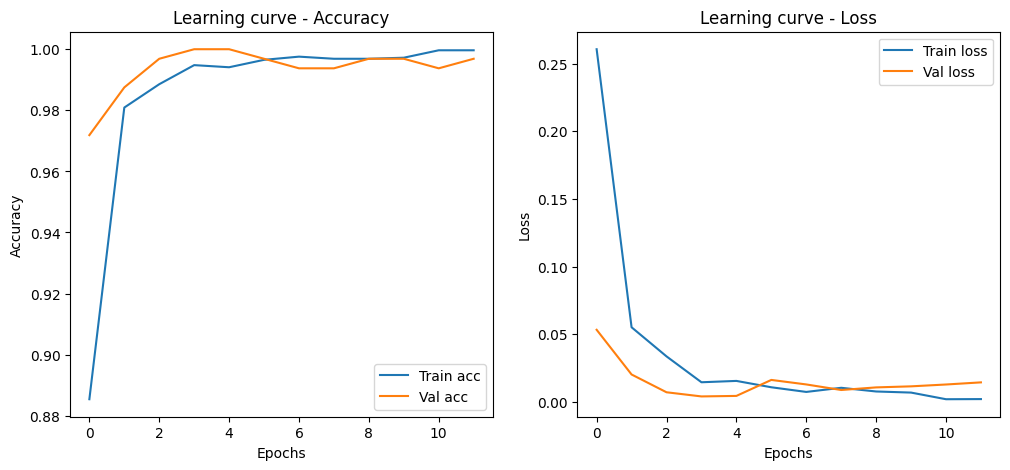

In [21]:
import matplotlib.pyplot as plt

# Graficar curva de aprendizaje del último fold
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning curve - Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning curve - Loss')

plt.show()


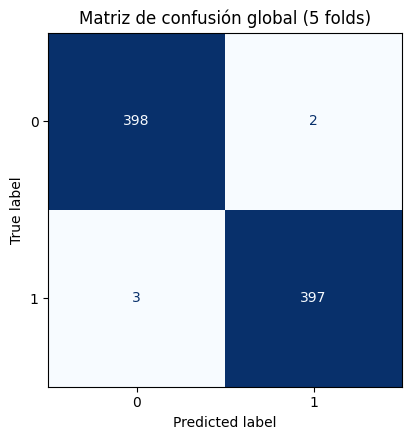

In [25]:
# Antes del for
all_y_true = []
all_y_pred = []

# Dentro del for, después de predecir en cada fold:
y_pred = (y_prob >= 0.5).astype(int)

# Acumular
all_y_true.extend(y_te.tolist())
all_y_pred.extend(y_pred.tolist())

# Dall_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

cm_global = confusion_matrix(all_y_true, all_y_pred, labels=[0,1])

fig, ax = plt.subplots(figsize=(4.5, 4.5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_global, display_labels=[0,1])
disp.plot(cmap='Blues', ax=ax, values_format='d', colorbar=False)
ax.set_title('Matriz de confusión global (5 folds)')
plt.tight_layout()
plt.savefig("figs_cv/confusion_global.png", dpi=150)
plt.show()
